In [1]:
# 引入依赖库
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing
from utils import *
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import os
import math
import numpy as np
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas import DataFrame, concat
from sklearn.model_selection import KFold

/root/miniconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 必要参数定义
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 训练设备,如果NVIDIA GPU已配置，会自动使用GPU训练
train_ratio = 0.8  # 训练集比例
val_ratio = 0.1  # 验证集比例
test_ratio = 0.1  # 测试集比例
batch_size = 50  # 批大小，若用CPU，建议为1
input_length = 4  # 每个batch的输入数据长度，多步预测建议长，单步预测建议短
output_length = 1  # 每个batch的输出数据长度，1为单步预测，1以上为多步预测
loss_function = 'MSE'  # 损失函数定义
learning_rate = 0.001  # 基础学习率
weight_decay = 0.001  # 权重衰减系数
num_blocks = 2  # lstm堆叠次数
dim = 128  # 隐层维度
interval_length = 150000  # 预测数据长度，最长不可以超过总数据条数
scalar = True  # 是否使用归一化
scalar_contain_labels = True  # 归一化过程是否包含目标值的历史数据
target_value = 'Temperature (C)'  # 需要预测的列名，可以在excel中查看
# 多步，单步标签
if output_length > 1:
    forecasting_model = 'multi_steps'
else:
    forecasting_model = 'one_steps'

In [3]:
csv_path = "./weatherHistory.csv"
df = pd.read_csv(csv_path)

In [4]:
print(df.shape)

(96453, 8)


In [5]:
# 原始数据集存在重复项，要进行去重
df.drop_duplicates(subset=["date"],keep='first',inplace=True)

In [6]:
# checking null values in our dataset
df.isna().sum()

date                        0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
dtype: int64

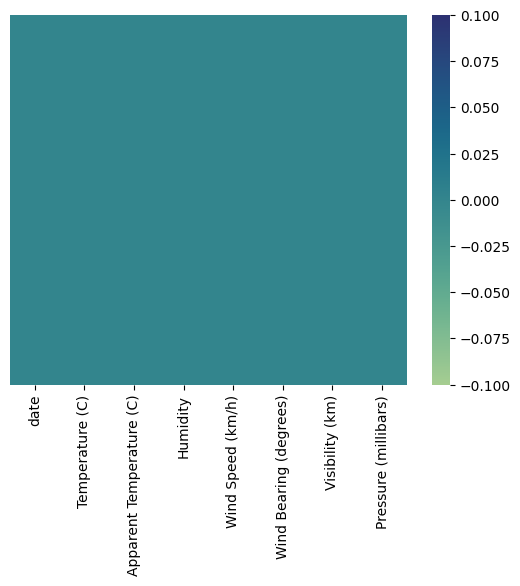

In [7]:
import seaborn as sns
sns.heatmap(df.isna(),yticklabels=False,cmap='crest')
plt.show()

In [8]:
df_1=df.copy()

In [9]:
df.columns

Index(['date', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)'],
      dtype='object')

In [10]:
# getting the datatypes of all the columns having null values
# first storing all the column names in a list having null values
col = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)']
df = df[col]
df[col].dtypes

Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)        int64
Visibility (km)             float64
Pressure (millibars)        float64
dtype: object

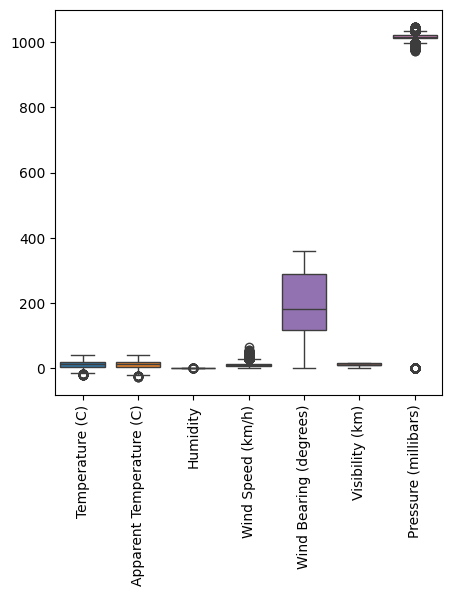

In [11]:
# plotting a boxplot
plt.figure(figsize=(5,5))
sns.boxplot(data=df)
plt.xticks(rotation='vertical')
plt.show()

In [12]:
# getting the quartile one and quartile 3 values of each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
# finally calculating the interquartile range IQR
IQR = Q3 - Q1

In [13]:
# if the values fall behind Q1 - (1.5 * IQR) or above Q3 + 1.5*IQR,
#then it is been defined as outlier
((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

Temperature (C)               44
Apparent Temperature (C)      22
Humidity                      46
Wind Speed (km/h)           3020
Wind Bearing (degrees)         0
Visibility (km)                0
Pressure (millibars)        4400
dtype: int64

In [14]:
mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
mask

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
96448,False,False,False,False,False,False,False
96449,False,False,False,False,False,False,False
96450,False,False,False,False,False,False,False
96451,False,False,False,False,False,False,False


In [15]:
for i in mask.columns:
    df[i].astype('float')
    temp = df[i].median()
    df.loc[mask[i], i] = temp

In [16]:
# outliers are now being handled and are replaced with that column's median value
((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()

Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
dtype: int64

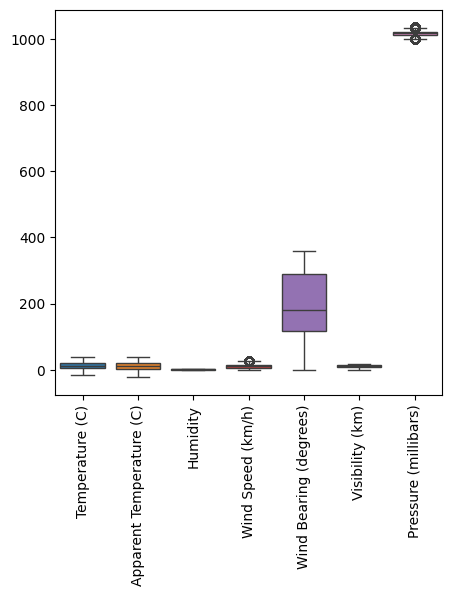

In [17]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df)
plt.xticks(rotation='vertical')
plt.show()

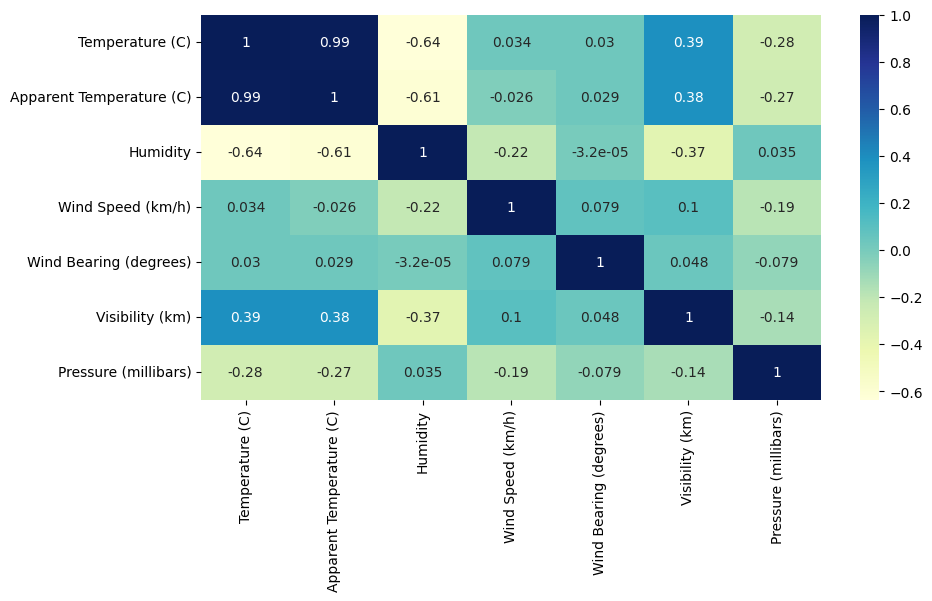

In [18]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
plt.show()

In [19]:
feature_keys = [
    'Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)'
]

date_time_key = "date"

In [20]:
df = pd.concat([df_1['date'], df], axis=1)

In [21]:
features = df[feature_keys]
features.index = df[date_time_key]
features.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
date,,,,,,,
2006-04-01 00:00:00.000 +0200,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13
2006-04-01 01:00:00.000 +0200,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63
2006-04-01 02:00:00.000 +0200,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94
2006-04-01 03:00:00.000 +0200,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41
2006-04-01 04:00:00.000 +0200,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51


In [22]:
df['Date Time'] = pd.to_datetime(df['date'])  # 确保时间列是日期时间格式
df.set_index('Date Time', inplace=True)  # 将时间列设为索引


# 选择目标列和观察列
target = df['Temperature (C)']
observed_cov = df[[ 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)']]

In [23]:
selected_columns = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)']

In [24]:
df_1=df[selected_columns]
df_1.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Date Time,,,,,,,
2006-04-01 00:00:00+02:00,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13
2006-04-01 01:00:00+02:00,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63
2006-04-01 02:00:00+02:00,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94
2006-04-01 03:00:00+02:00,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41
2006-04-01 04:00:00+02:00,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51


In [25]:
#  读取数据
df = df_1[:interval_length]
features_num = 7  # 请手动输入特征维度数量
if features_num > 1:
    features_ = df.values
else:
    features_ = df[target_value].values
labels_ = df[target_value].values
# 初步划分训练集、验证集、测试集
split_train_val, split_val_test = int(len(features_)*train_ratio),\
                                  int(len(features_)*train_ratio)+int(len(features_)*val_ratio)

In [26]:
#  数据标准化
if scalar:
    #min-max scalar
    train_features_ = features_[:split_train_val]
    val_test_features_ = features_[split_train_val:]
    scalar = preprocessing.MinMaxScaler()
    if features_num == 1:
        train_features_ = np.expand_dims(train_features_, axis=1)
        val_test_features_ = np.expand_dims(val_test_features_, axis=1)
    train_features_ = scalar.fit_transform(train_features_)
    val_test_features_ = scalar.transform(val_test_features_)
    # 重新将数据进行拼接
    features_ = np.vstack([train_features_, val_test_features_])
    if scalar_contain_labels:
        labels_ = features_[:, -1]

if len(features_.shape) == 1:
    features_ = np.expand_dims(features_,0).T
features, labels = get_rolling_window_multistep(output_length, 0, input_length,
                                                features_.T, np.expand_dims(labels_, 0))

data preparing: 100%|██████████| 96425/96425 [02:23<00:00, 671.10it/s] 


In [27]:
#  构建数据集
labels = torch.squeeze(labels, dim=1)
features = features.to(torch.float32)
labels = labels.to(torch.float32)
split_train_val, split_val_test = int(len(features)*train_ratio), int(len(features)*train_ratio)+int(len(features)*val_ratio)
train_features, train_labels = features[:split_train_val], labels[:split_train_val]
val_features, val_labels = features[split_train_val:split_val_test], labels[split_train_val:split_val_test]
test_features, test_labels = features[split_val_test:], labels[split_val_test:]

In [28]:
#  数据管道构建，此处采用torch高阶API
train_Datasets = TensorDataset(train_features.to(device), train_labels.to(device))
train_Loader = DataLoader(batch_size=batch_size, dataset=train_Datasets)
val_Datasets = TensorDataset(val_features.to(device), val_labels.to(device))
val_Loader = DataLoader(batch_size=batch_size, dataset=val_Datasets)
test_Datasets = TensorDataset(test_features.to(device), test_labels.to(device))
test_Loader = DataLoader(batch_size=batch_size, dataset=test_Datasets)

In [29]:
# 定义 CNN-LSTM 模型
class CNN_LSTM_Attention(nn.Module):
    def __init__(self):
        super(CNN_LSTM_Attention, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=7, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=4)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128,1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch, n_vars, n_in] -> [batch, n_in, n_vars]
        x = self.conv1d(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # 调整为 [batch, 时间步, 通道数]
        lstm_out, _ = self.lstm1(x)
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        lstm_out, _ = self.lstm2(attn_output)
        x = lstm_out[:, -1, :]  # 获取最后一个时间步的输出
        x = self.fc(x)
        return x

In [30]:
# 创建模型、损失函数和优化器
model = CNN_LSTM_Attention()
model.to(device)
if loss_function == 'MSE':
    loss_func = nn.MSELoss(reduction='mean')

In [31]:
#  训练代数定义
epochs = 101
#  优化器定义，学习率衰减定义
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3, eta_min=0.00001)

In [ ]:
# 设置 epoch 从 101 开始
start_epoch = 101

# 加载第100个 epoch 保存的模型权重
model.load_state_dict(torch.load('./CNN_LSTM_Attention_0001/cnn_lstm_epoch_100.pth'))
print(f"Model loaded from epoch 100, continuing training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)

for epoch in range(start_epoch, epochs + 1):
    # 训练
    model.train()
    train_loss_sum = 0
    step = 1
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0, 2, 1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()

    # 记录每个 epoch 的训练损失
    train_loss_history.append(train_loss_sum)
    
    print(f"epoch = {epoch}")
    print(f'train_loss = {train_loss_sum}')

    # 验证
    model.eval()
    val_loss_sum = 0
    val_step = 1
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()

    # 记录每个 epoch 的验证损失
    val_loss_history.append(val_loss_sum)

    print(f'val_loss = {val_loss_sum}')
    if epoch == start_epoch:  # 第101个 epoch
        val_best = val_loss_sum
    else:
        if val_best > val_loss_sum:
            val_best = val_loss_sum
            torch.save(model.state_dict(), './CNN_LSTM_Attention_0001/cnn_lstm_best')  # 保存最好权重
            print("val_best changed")

    # 每隔一个 epoch 保存一次模型
    if epoch % 1 == 0:
        torch.save(model.state_dict(), f'./CNN_LSTM_Attention_0001/cnn_lstm_epoch_{epoch}.pth')  # 保存模型
        print(f"Model saved at epoch {epoch}")

print(f"best val loss = {val_best}")
print("——————————————————————Training Ends——————————————————————")

# 绘制损失曲线
plt.figure(figsize=(10,6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

——————————————————————Training Starts——————————————————————


/tmp/ipykernel_7108/3874496585.py:19: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


epochs = 0
train_loss = 25.160856455360772
val_loss = 2.5571112040197477
epochs = 1
train_loss = 10.49400480229815
val_loss = 0.8895707730844151
val_best change
epochs = 2
train_loss = 8.351337482818053
val_loss = 0.9893742037093034
epochs = 3
train_loss = 6.889149926813843
val_loss = 0.7512895373365609
val_best change
epochs = 4
train_loss = 6.26666943278542
val_loss = 0.6421180616744095
val_best change
epochs = 5
train_loss = 5.6501652829756495
val_loss = 0.48916618817747803
val_best change
epochs = 6
train_loss = 5.013836724214343
val_loss = 0.4376256810428458
val_best change
epochs = 7
train_loss = 4.760752648427115
val_loss = 0.528096083260607
epochs = 8
train_loss = 4.515664736700273
val_loss = 0.4505846939282492
epochs = 9
train_loss = 4.414910763654916
val_loss = 0.37240195652702823
val_best change
epochs = 10
train_loss = 4.214499810736015
val_loss = 0.4280964866775321
Model saved at epoch 10
epochs = 11
train_loss = 4.148047372246765
val_loss = 0.4912895209126873
Model saved 

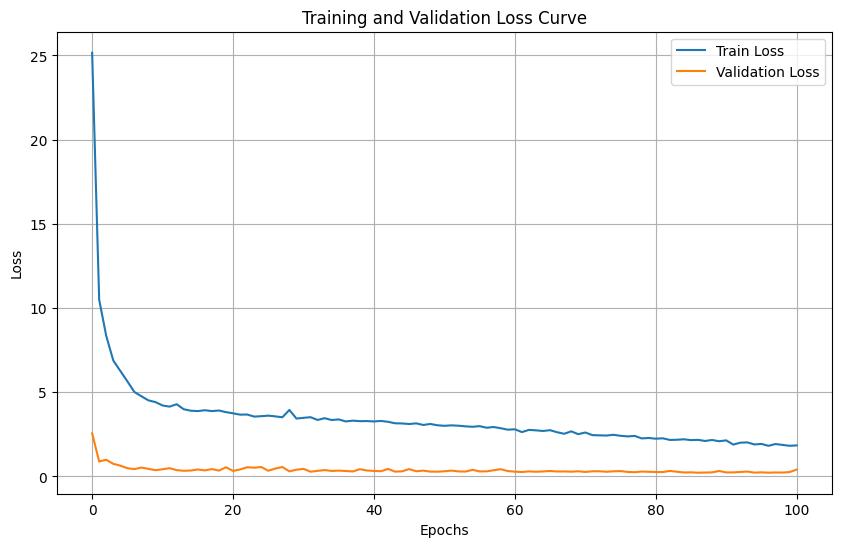

In [32]:
# 训练及验证循环
train_loss_history = []
val_loss_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)

for epoch in range(epochs):
    # 训练
    model.train()
    train_loss_sum = 0
    step = 1
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0,2,1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()

    # 记录每个 epoch 的训练损失
    train_loss_history.append(train_loss_sum)
    
    print("epochs = " + str(epoch))
    print('train_loss = ' + str(train_loss_sum))

    # 验证
    model.eval()
    val_loss_sum = 0
    val_step = 1
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()

    # 记录每个 epoch 的验证损失
    val_loss_history.append(val_loss_sum)

    print('val_loss = ' + str(val_loss_sum))
    if epoch == 0:
        val_best = val_loss_sum
    else:
        if val_best > val_loss_sum:
            val_best = val_loss_sum
            torch.save(model.state_dict(), './CNN_LSTM_Attention_0001/cnn_lstm_best')  # 保存最好权重
            print("val_best change")
    
    # 每隔一个epoch保存一次模型, 从第10个epoch开始
    if epoch >= 10 and epoch % 1 == 0:
        torch.save(model.state_dict(), f'./CNN_LSTM_Attention_0001/cnn_lstm_epoch_{epoch}.pth')  # 保存模型
        print(f"Model saved at epoch {epoch}")

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")

# 绘制损失曲线
plt.figure(figsize=(10,6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
#  测试集预测
model.load_state_dict(torch.load('./CNN_LSTM_Attention_0001/cnn_lstm_epoch_84.pth'))  # 调用权重
test_loss_sum = 0
step = 0
#  测试集inference
print("——————————————————————Testing Starts——————————————————————")
for step, (feature_, label_) in enumerate(test_Loader):
    feature_ = feature_.permute(0, 2, 1)
    with torch.no_grad():
         if step ==0:
            prediction = model(feature_)
            pre_array = prediction.cpu()
            label_array = label_.cpu()
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
         else:
            prediction = model(feature_)
            pre_array = np.vstack((pre_array, prediction.cpu()))
            label_array = np.vstack((label_array, label_.cpu()))
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
print("test loss = " + str(test_loss_sum))
print("——————————————————————Testing Ends——————————————————————")

——————————————————————Testing Starts——————————————————————
test loss = 0.2627862687004381
——————————————————————Testing Ends——————————————————————


——————————————————————Post-Processing——————————————————————


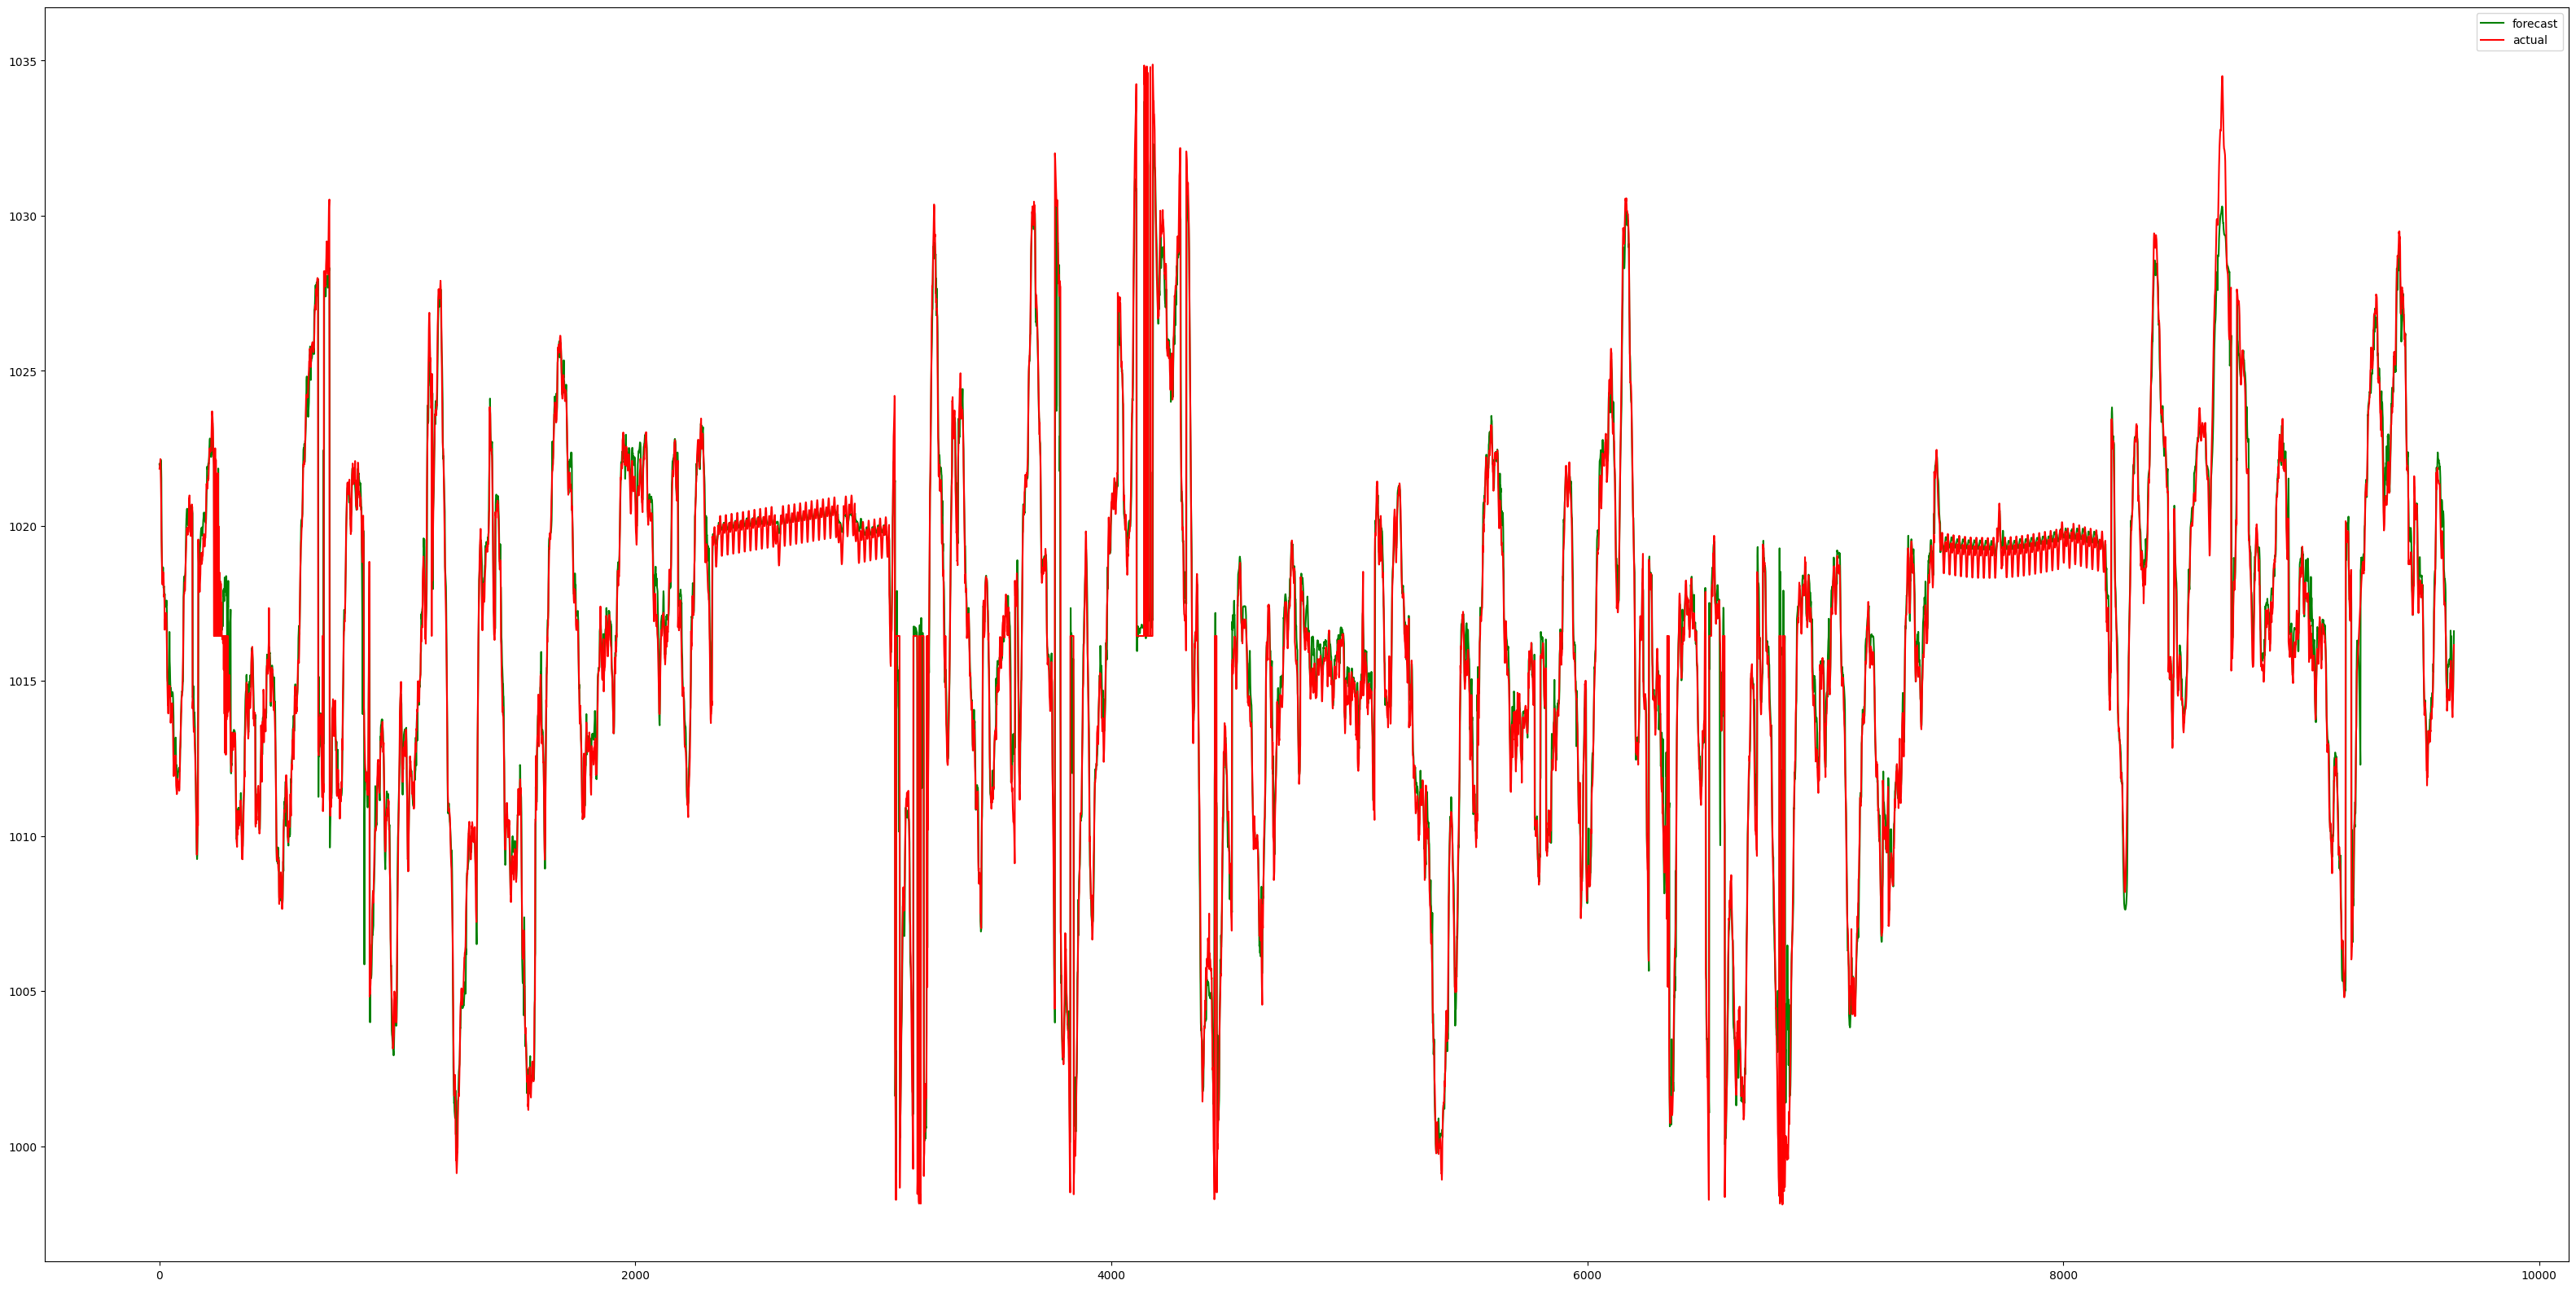

MSE loss=1.8398274616562424
MAE loss=0.6161835988287387
MAPE loss=0.0006067115132609314
R2=0.9491954896312325


In [33]:
# 数据后处理，单步预测绘制全部预测值的图像，多步预测仅绘制第一个batch的输出图像
#  逆归一化过程及绘制图像
print("——————————————————————Post-Processing——————————————————————")
#test_labels = torch.tensor(test_labels)

if scalar_contain_labels and scalar :
    pre_inverse = []
    test_inverse = []
    if features_num == 1 and output_length == 1:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    elif features_num>1:
        if isinstance(pre_array, np.ndarray):
            pre_array = torch.from_numpy(pre_array)
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(pre_array[0].shape[0], features_num-1),torch.unsqueeze(pre_array[pre_slice], dim=1)), 1))[:,-1]
            test_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(test_labels[0].shape[0], features_num-1), torch.unsqueeze(test_labels[pre_slice], dim=1)), 1))[:,-1]
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse)
        test_labels = np.array(test_inverse)
    else:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0], "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels, "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    #  计算衡量指标
    MSE_l = mean_squared_error(test_labels, pre_array)
    MAE_l = mean_absolute_error(test_labels, pre_array)
    MAPE_l = mean_absolute_percentage_error(test_labels, pre_array)
    R2 = r2_score(test_labels, pre_array)
    print('MSE loss=%s'%MSE_l)
    print('MAE loss=%s'%MAE_l)
    print('MAPE loss=%s'%MAPE_l)
    print('R2=%s'%R2)

else:
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0].cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels.cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    MSE_l = mean_squared_error(test_labels.cpu(), pre_array)
    MAE_l = mean_absolute_error(test_labels.cpu(), pre_array)
    MAPE_l = mean_absolute_percentage_error(test_labels.cpu(), pre_array)
    R2 = r2_score(test_labels.cpu(), pre_array)
    print('MSE loss=%s'%MSE_l)
    print('MAE loss=%s'%MAE_l)
    print('MAPE loss=%s'%MAPE_l)
    print('R2=%s'%R2)